<a href="https://colab.research.google.com/github/secutron/Practice_Ignite/blob/main/coders_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#coders_02

In [1]:
#@title MIT License
#
# Copyright (c) 2022 secutron@naver.com
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

## 개요

- 이전 [coders_01](https://github.com/secutron/Practice_Coders/blob/main/coders_01.ipynb)에서 Vanilla AutoEncoder를 구현하고, 몇 가지 실험을 통해 다음과 같은 현상을 관찰하였다.

    - MNIST 데이터 세트 중 '0' 형상을 가진 샘플만으로 학습시킨 Vanilla AutoEncoder 네트워크는, 
    - 학습에 이용된 적이 없는 임의의 샘플('1' ~ '9' 영상, FashionMNIST 영상, 잡음 영상)을 입력할 경우에도,
    - 지속적으로 학습된 형태인 '0' 영상으로 복원

- 인터넷 상에 AutoEncoder 학습을 MNIST의 모든 샘플, 즉 '0' 부터 '9'까지를 모두 이용하는 설명도 있으므로, ~~매우 귀찮지만~~ 추가 실험을 진행하도록 한다.

- 실험 1. 이전 [coders_01](https://github.com/secutron/Practice_Coders/blob/main/coders_01.ipynb)과 마찬가지로, 입력과 출력이 동일하도록 세팅된 상태에서 MNIST의 모든 클래스('0' 부터 '9'까지 10종)를 이용하여 coders 구조(encoder-decoder)의 네트워크가 학습될 수 있음을 확인한다. 

    - 학습 입력: mnist '학습' 세트 중 '0'부터 '9'에 해당하는 숫자 영상 데이터
    - 학습 출력: (입력된 영상과 근사한) 영상

- 실험 2. 상기 네트워크가 학습되었음을 확인하였다면, 평가 세트에서 선택한 임의의 샘플을 encoder 네트워크 파트에 입력하고 이를 다시 decoder 네트워크 파트를 이용해 복원할 수 있음을 추가 확인한다.

    - 시험 입력: mnist '평가' 세트 중 임의의 숫자 영상 데이터
    - 시험 출력: (당연히 입력된 영상과 근사한) 영상

- 실험 3. 상기 네트워크에, 학습에서 사용하지 않은 임의의 데이터를 입력할 때 발생하는 현상을 확인해본다.
 
    - T.4번 입력: fashion mnist 중 임의의 영상 데이터
    - T.4번 출력: ??
    - T.5번 입력: 임의(random) 생성된 영상 데이터
    - T.5번 출력: ??
 
- 다음 주제: 복원되는 영상이 모두 흐릿하게 보인다. 학습을 너무 적게 시켜서인가? 학습을 더 오래 진행한다면 이런 흐릿하게 보이는 문제는 사라지는가?

    - coders_03에서 확인해보자.


## Vanilla Autoencoder 준비


In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import copy

import torch

from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import ToTensor, Lambda, Compose


In [3]:
class AutoEncoder(torch.nn.Module):
    
    def __init__(self, latent_dim):
        
        super(AutoEncoder, self).__init__()
        
        self.latent_dim = latent_dim
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(784, 128),
            torch.nn.Tanh(),
            torch.nn.Linear(128, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 12),
            torch.nn.Tanh(),
            torch.nn.Linear(12, latent_dim)
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 12),
            torch.nn.Tanh(),
            torch.nn.Linear(12, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 128),
            torch.nn.Tanh(),
            torch.nn.Linear(128, 784),
            torch.nn.Sigmoid()
        )
        
        
    def decode(self, z):
        return self.decoder(z)
    
    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        z = self.encode(x)
        return z, self.decode(z)

## Utils 준비

In [4]:
def plot_digits(view_data, decoded_data=None):
    
    n_rows = 2 if decoded_data is not None else 1
    n_cols = len(view_data)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    
    if decoded_data is not None:
        for i in range(n_cols):
            axes[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray')
            axes[0][i].set_xticks(())
            axes[0][i].set_yticks(())
        
        for i in range(n_cols):
            axes[1][i].clear()
            axes[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
            axes[1][i].set_xticks(())
            axes[1][i].set_yticks(())
    
    else:
        for i in range(n_cols):
            axes[i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray')
            axes[i].set_xticks(())
            axes[i].set_yticks(())
    
    plt.show()

## 학습 데이터 준비

In [5]:
torch.manual_seed(1337) 

batch_size = 64 

transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])

mnist_trainset = MNIST(root='./data/', train=True, transform=transforms, download=True) 
train_loader = torch.utils.data.DataLoader(dataset=mnist_trainset, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## 실험 1. 학습 진행 및 경과 확인

- 이전 [coders_01](https://github.com/secutron/Practice_Coders/blob/main/coders_01.ipynb)과 마찬가지로, 입력과 출력이 동일하도록 세팅된 상태에서 MNIST의 모든 클래스('0' 부터 '9'까지 10종)를 이용하여 coders 구조(encoder-decoder)의 네트워크가 학습될 수 있음을 확인한다. 

    - 학습 입력: mnist '학습' 세트 중 '0'부터 '9'에 해당하는 숫자 영상 데이터
    - 학습 출력: (입력된 영상과 근사한) 영상

Epoch:  0 | Step:  0 | train loss: 0.2325


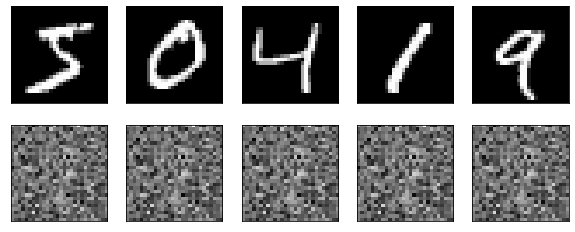

Epoch:  0 | Step:  780 | train loss: 0.0479


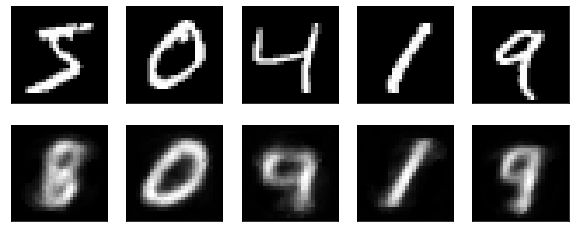

Epoch:  5 | Step:  0 | train loss: 0.0376


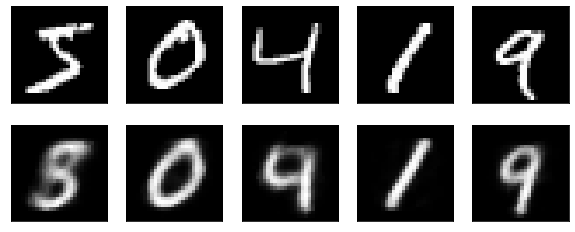

Epoch:  5 | Step:  780 | train loss: 0.0352


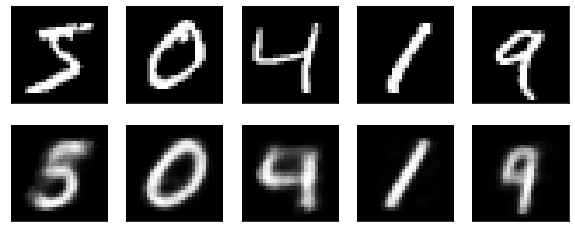

Epoch:  19 | Step:  0 | train loss: 0.0331


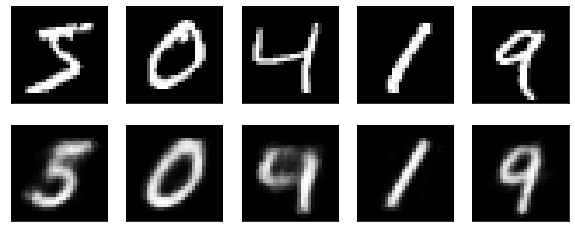

Epoch:  19 | Step:  780 | train loss: 0.0349


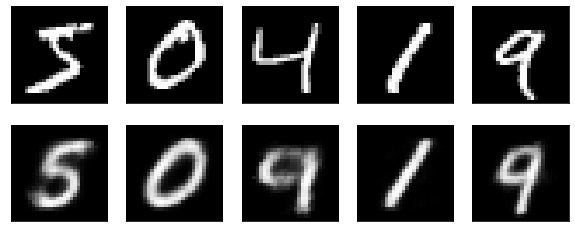

In [8]:
# prepare original data for plotting
n_plots = 5
view_data = mnist_trainset.data[:n_plots].view(-1, 28*28).type(torch.FloatTensor) / 255.

epochs = 20
lr = 0.005 

autoencoder = AutoEncoder(latent_dim=3)

if torch.cuda.is_available():
  autoencoder.cuda()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
loss_func = torch.nn.functional.mse_loss 

for epoch in range(epochs):
    for step, (x, y) in enumerate(train_loader):

        encoded, decoded = autoencoder(x)

        loss = loss_func(decoded, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

        if step % 780 == 0 and epoch in [0, 5, epochs - 1]: # 50000 / 64(batch_size) ~ 781
            print('Epoch: ', epoch, '| Step: ', step, '| train loss: %.4f' % loss.data.item())

            _, decoded_data = autoencoder(view_data)
            
            plot_digits(view_data, decoded_data)

상기 결과에 나타난 그림의 의미는 다음과 같다.

- Epoch:  x | Step:  x | train loss: xxx)인 경우,
- 첫번째 다섯 개의 영상은 네트워크의 입력을 나타낸다.
- 두번째 다섯 개의 영상은 네트워크의 출력을 나타낸다.

학습과정에서는 다음과 같은 현상을 관찰하였다

- 학습 초기에는 네트워크가 잡음에 가까운 출력을 생성하였다. (Epoch: 0 | Step: 0 에 해당)
- 학습이 진행될수록 입력 데이터와 동일한 출력을 생성하였다. 
- 학습은 매우 빠르게 진행되었다. (불과 20 epoch 만에 그럴듯한 결과를 생성)



## 실험 2. 평가 샘플 복원

- 상기 네트워크가 학습되었음을 확인하였다면, 평가 세트에서 선택한 임의의 샘플을 encoder 네트워크 파트에 입력하고 이를 다시 decoder 네트워크 파트를 이용해 복원할 수 있음을 추가 확인한다.

    - 시험 입력: mnist '평가' 세트 중 임의의 숫자 영상 데이터
    - 시험 출력: (당연히 입력된 영상과 근사한) 영상

In [9]:
mnist_testset = MNIST(root='./data/', train=False, transform=transforms, download=True)

def get_one_image(dataset, index):
    return dataset[index][0]

# 평가 세트에서 샘플 하나 고르고 그림으로 출력
index = np.random.randint(0, len(mnist_testset), size=1)
selected_test_input = get_one_image(mnist_testset, index[0])

autoencoder.eval()
encoded, decoded = autoencoder(selected_test_input)

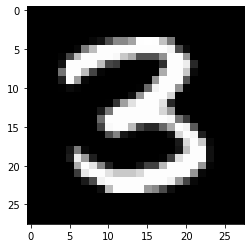

In [10]:
plt.imshow(np.reshape(selected_test_input.numpy(), (28, 28)), cmap='gray') 

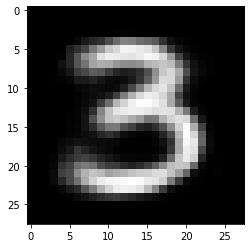

In [11]:
plt.imshow(np.reshape(decoded.detach().numpy(), (28, 28)), cmap='gray') 

# plt.imshow를 2번 이상 호출하면, 마지막 것만 보인다. 
# 이유는? 난 모르겠고 나중에 matplotlib이나 colab측이 해결해야 할 문제이다. 
# 그때까지 나는 앞으로도 이 예제에서처럼 블록으로 나누어 사용하려 한다. 고민을 낭비하지 않는다.

In [12]:
# 아래와 같이 인코더와 디코더로 따로 구분하여 해볼 수도 있다.

# 인터넷의 흔한 설명에서처럼, 
# encoded된 값과 디코더 네트워크만의 파라미터만 빼돌리면(?),,,
# 이를 이용해 원래의 데이터로 복구해서 가질 수 있는 상황 (이 뭔 개...)

autoencoder.eval()
encoded = autoencoder.encode(selected_test_input)

decoded = autoencoder.decode(encoded)

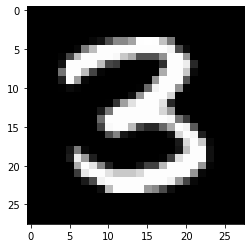

In [13]:
plt.imshow(np.reshape(selected_test_input.numpy(), (28, 28)), cmap='gray') # mnist는 픽셀이 1차원

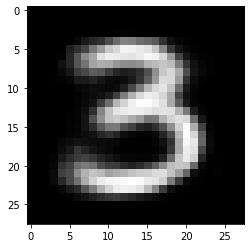

In [14]:
plt.imshow(np.reshape(decoded.detach().numpy(), (28, 28)), cmap='gray') 

상기 결과에서 생각해볼 부분은 다음과 같다.

- 다양한 형태의 숫자 영상으로 코더스 구조를 학습시킬 수 있었다.
- 또한 학습에 이용하지 않았던 새로운 형상의 숫자 영상을 입력하여 얻은 작은 차원의 encoded 값으로도, decoder가 동작하여 원래의 숫자 영상과 유사하게 복원할 수 있었다.
    - 기본적으로 MNIST 클래스 전부를 이용하여 학습시킨 코더스 네트워크에 MNIST 임의 샘플 영상을 입력하면 잘 복원시킨다.
- 복원된 영상은 입력 영상과 동일한가? 글쎄... 근사한 형태로, 뭔가 blur하다.


## 실험 3. 임의 데이터를 입력하는 경우

- 상기 네트워크에, 학습에서 사용하지 않은 임의의 데이터를 입력할 때 발생하는 현상을 확인해본다.

### T4. 숫자가 아닌 경우

- 만일 숫자가 아닌 영상을 입력하면 어떤 출력이 나올까?
    - T.4번 입력: fashion mnist 중 임의의 영상 데이터
    - T.4번 출력: 근사한 숫자 영상


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



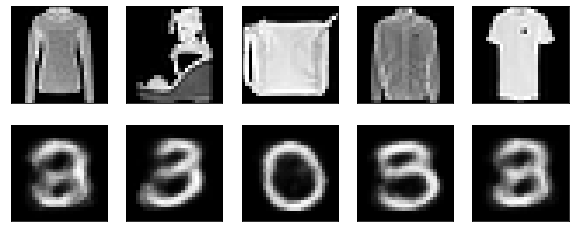

In [15]:
fashion_testset = FashionMNIST('./data', train=False, transform=transforms, download=True)

def get_multiple_images(dataset, indices):
    return torch.stack([dataset[i][0] for i in indices], dim=0)

indices = np.random.randint(0, len(fashion_testset), size=5)

selected_test_inputs = get_multiple_images(fashion_testset, indices)

# 의류/잡화로 구성된 FashionMNIST 데이터 세트에서 샘플을 5개 고르고 코더스에서 복원한 영상을 출력
autoencoder.eval()
encoded, decoded = autoencoder(selected_test_inputs)

plot_digits(selected_test_inputs, decoded)

### T5. 잡음 경우

- 숫자가 아닌 영상도 숫자인 것처럼 출력함을 위에서 확인해 보았다. 만일 임의의 랜덤 신호인 잡음을 입력한다면 어떨까?
    - T.5번 입력: 임의(random) 생성된 영상 데이터
    - T.5번 출력: 그래도 숫자 영상

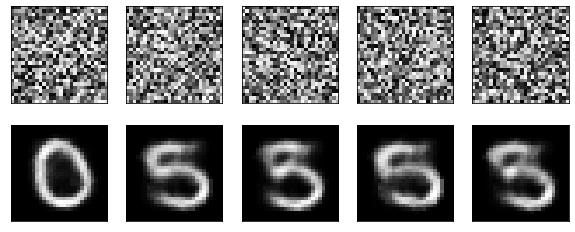

In [16]:
selected_test_inputs = torch.rand(5, 1, 784) * 255

# 잡음을 입력하고, 코더스에서 복원한 영상을 출력
autoencoder.eval()
encoded, decoded = autoencoder(selected_test_inputs)

plot_digits(selected_test_inputs, decoded)


상기 몇 가지 실험을 통해, 심지어 랜덤한 시그널 영상까지도 모두 0으로 복원함을 보았다. ~~이거 너무하는 거 아니냐고~~


##다음 주제: 

- 복원되는 영상이 모두 흐릿하게 보인다. 학습을 너무 적게 시켜서인가? 학습을 더 오래 진행한다면 이런 흐릿하게 보이는 문제는 사라지는가?

- [coders_03](...)에서 확인해보자.